# Input

In [ ]:
bacmman_path = 'D:\Daniel\BACMMAN\Timelapse' # Folder that contains the dataset
dataset_list = ['230425_1sec', '230201_DT23', '230504_2sec', '230425_5sec', '230504_5sec'] # Bacmman dataset name

groups = ['230425_1sec', '230201_2sec', '230504_2sec', '230425_5sec', '230504_5sec']

filters = {'Spot_detection':'TrackLength > 1'}

# Import dataset

In [ ]:
from pyberries.data import DatasetPool

data = (DatasetPool(path=bacmman_path, dsList=dataset_list, metadata={'Spot_detection':'DateTime'}, groups=groups, filters=filters)
        .drop_duplicates(object_name='Spot_detection', subset=['Dataset', 'Position', 'TrackHeadIndices'])
        )

# Datasets summary

In [ ]:
data.describe('mean')

# Figures

## Spot lifetime histogram

In [ ]:
import seaborn.objects as so
from seaborn import axes_style

(
    so.Plot(data.Spot_detection, x='TrackLength', color='Group')
    .add(so.Bars(), so.Hist(binwidth=1, stat='probability', common_norm=False))
    .scale(color='deep')
    .limit(x=(0, 30), y=(None, None))
    .label(x="Spot lifetime (frames)", y="Probability", title='', color='')
    .theme({**axes_style("whitegrid"), "grid.linestyle": ":"})
)

## Spot lifetime histogram fit

In [ ]:
from pyberries.data import Fit, get_histogram

hist = get_histogram(data.Spot_detection, col='TrackLength', binsize=2, groupby='Group', density=True)
lifetime_fit = Fit(hist, x='bins', y='height', model_type='biexp_decay',
                   groupby='Group', p0=[hist.bins.iloc[0], 1, hist.bins.iloc[0]/10, 0.1])

### Show histogram fit

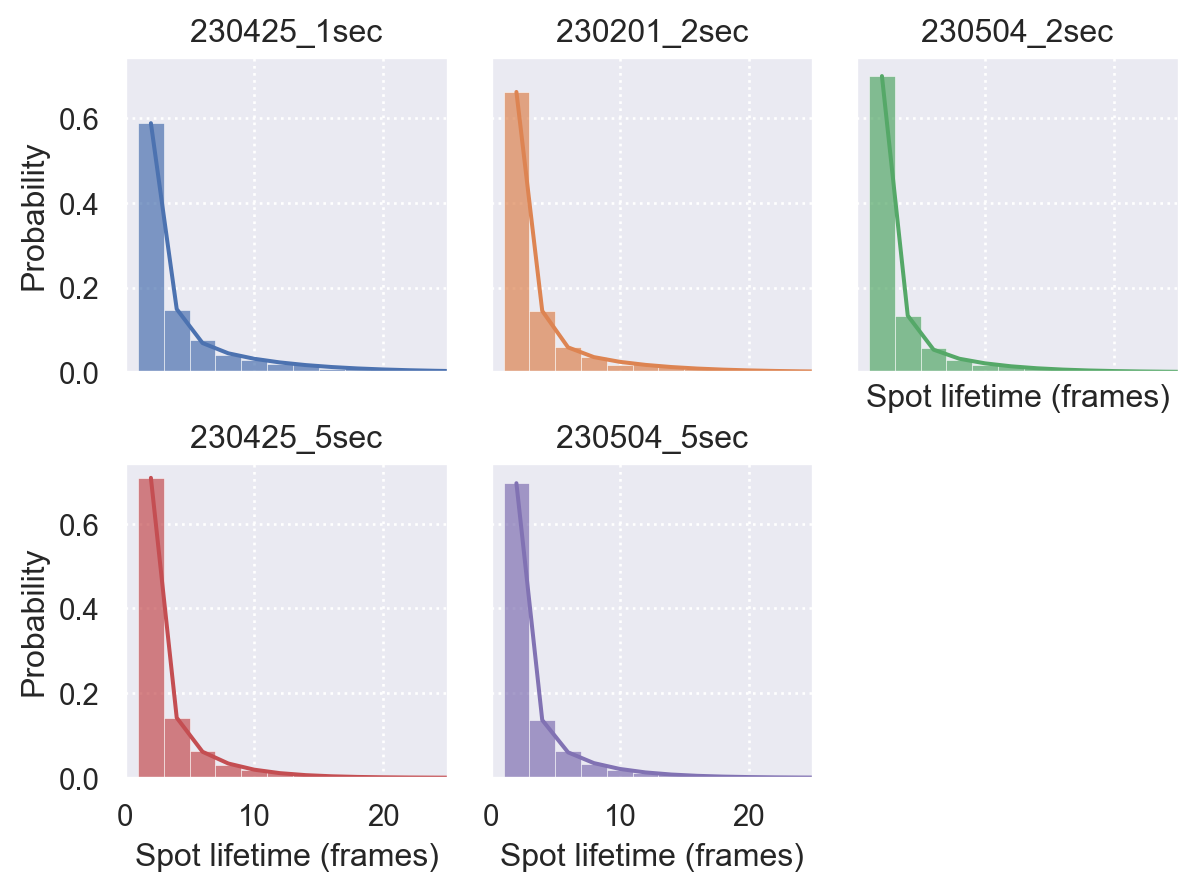

In [9]:
import seaborn.objects as so
from seaborn import axes_style

(
    so.Plot(lifetime_fit.data, x='bins', color='Group')
    .facet(col='Group', wrap=3)
    .add(so.Bars(), y='height', legend=False)
    .add(so.Line(), y='Fit', legend=False)
    .scale(color='deep')
    .limit(x=(0, 25), y=(None, None))
    .label(x="Spot lifetime (frames)", y="Probability", color='')
    .theme({**axes_style("darkgrid"), "grid.linestyle": ":"})
)

### Rates summary

In [ ]:
import seaborn.objects as so
from seaborn import axes_style

rates = lifetime_fit.get_rates(dt=[1, 2, 2, 5, 5])
rates[['Date','Frame']] = rates['Group'].str.split('_',expand=True)
display(rates)

(
    so.Plot(rates, x='Rate', y='Frame', color='Rate_type')
    .add(so.Dots(), so.Shift(y=-.1))
    .add(so.Dot(pointsize=7), so.Agg())
    .add(so.Range(linewidth=2), so.Est(errorbar="sd"))
    .scale(color='deep')
    .limit(x=(None, None), y=(None, None))
    .label(x="Dissociation rate (s$^{-1}$)", y="Frame interval (s)", title='', color='')
    .theme({**axes_style("darkgrid"), "grid.linestyle": ":"})
)

### Bar plot of fitted populations

In [ ]:
import seaborn.objects as so
from seaborn import axes_style

(
    so.Plot(data=rates, x='Population', y='Frame', color='Rate_type')
    .add(so.Bars(), so.Agg(), so.Stack())
    .add(so.Range(linewidth=2, color='0'), so.Est(errorbar="sd"), data=rates.query('Rate_type == "Fast"'))
    .scale(color='deep')
    .limit(x=(0, 1), y=(None, None))
    .label(x="Population (fraction)", y="", title='', color='')
    .theme({**axes_style("whitegrid"), "grid.linestyle": ":"})
)

## Spot lifetime quantile plot

In [ ]:
import seaborn.objects as so
from seaborn import axes_style

timeseries_parameters = {'metric':'Quantile', # Metric to be plotted
                         'objectName':'TrackLength',
                         'timeBin':1,
                         'quantile':0.9
                        }
data.get_timeseries(object_name='Spot_detection', **timeseries_parameters)

(
    so.Plot(data.Spot_detection_timeseries, x='Time_min', y='Column_quantile', color='Group')
    .add(so.Dots())
    .add(so.Line(), y='Column_quantile_movmean')
    .scale(color='deep')
    .limit(x=(None, None), y=(None, None))
    .label(x="Time (min)", y="Track length (frames)", title='', color='')
    .theme({**axes_style("darkgrid"), "grid.linestyle": ":"})
)

## Fraction of spots with tracklength > threshold

In [ ]:
import seaborn.objects as so
from seaborn import axes_style

data.add_columns(object_name='Spot_detection', metrics=['is_col_larger'], thr=20, col='TrackLength')

(
    so.Plot(data.Spot_detection, x='Group', y='Comparison', color='Group')
    .add(so.Bar(), so.Agg(), legend=False)
    .add(so.Range(), so.Est(), legend=False)
    .scale(y=so.Continuous(), color='deep')
    .limit(x=(None, None), y=(None, None))
    .label(x="", y="Fraction of tracks", title='Fraction of tracks longer than 20 frames')
    .theme({**axes_style("darkgrid"), "grid.linestyle": ":"})
)

## Ensemble fluorescence decay fitting

In [ ]:
from pyberries.data import Fit

bleaching_fit = Fit(data.Bacteria_large, x='Frame', y='SNR', groupby='Group', model_type='monoexp_decay_offset', p0=[data.Bacteria_large.SNR.iloc[0], 1, 0])

### Fit plotting

In [ ]:
import seaborn.objects as so
from seaborn import axes_style

(
    so.Plot(bleaching_fit.data, x='Frame', color='Group')
    .layout(size=(12, 4))
    .facet(col='Group', wrap=5)
    .add(so.Line(alpha=.8), so.Agg(), y='SNR', legend=False)
    .add(so.Band(), so.Est(errorbar='se'), y='SNR', legend=False)
    .add(so.Line(linestyle='--'), y='Fit', legend=False)
    .scale(color='deep')
    .limit(x=(None, None), y=(None, None))
    .label(x="Illumination time (sec)", y="Fluorescence (AU)", color='')
    .theme({**axes_style("darkgrid"), "grid.linestyle": ":"})
)

### Fit parameters boxplot

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyberries.plots import boxplot

rates = bleaching_fit.get_fit_parameters(param_names=['Amplitude', 'Rate', 'Offset'])
rates['Position'] = rates['Group'].str.split('-', expand=True).iloc[:,0]

plot_args = {'x':'Position',
             'y':'Fitted_param',
             'xlim':(None, None),
             'xlabel':'',
             'width':.5,
             'fliersize':3,
             'linewidth':1,
             'palette':'muted'
            }

f, (ax1, ax2, ax3) = plt.subplots(3, 1, dpi=130, sharex=True)
ax1 = boxplot(rates.query('Param_name == "Amplitude"'), ylim=(None, 5000), ylabel='Amplitude', ax=ax1, **plot_args)
ax2 = boxplot(rates.query('Param_name == "Rate"'), ylim=(0, None), ylabel='Rate', ax=ax2, **plot_args)
ax3 = boxplot(rates.query('Param_name == "Offset"'), ylabel='Offset', ax=ax3, **plot_args)
sns.despine()
_ = plt.xticks(rotation=90)

### Fit parameters stripplot

In [ ]:
import seaborn.objects as so
from seaborn import axes_style

rates = bleaching_fit.get_fit_parameters(param_names=['Amplitude', 'Rate', 'Offset'])
rates['Dataset'] = rates['Group'].str.split('-', expand=True).iloc[:,0]

(
    so.Plot(rates, x='Dataset', y='Fitted_param', color='Dataset')
    .facet(row='Param_name')
    .add(so.Dot(), legend=False)
    .scale(color='deep')
    .share(y=False)
    .limit(y=(None, None))
    .label(x="", y="", color='')
    .theme({**axes_style("darkgrid"), "grid.linestyle": ":"})
)

### Rates summary

In [ ]:
import matplotlib.pyplot as plt
from pyberries.plots import histplot

rates = bleaching_fit.get_rates()
# rates['Dataset'] = rates['Group'].str.split('-', expand=True).iloc[:,0]

plot_args = {'x':'Rate',
            #  'hue':'Dataset',
             'binwidth':0.005,
             'stat':'probability',
             'common_norm':False,
             'xlim':(None, None),
             'ylim':(None, None),
             'xlabel':'Bleaching rate (s$^{-1}$)',
             'ylabel':'Probability',
             'title':f'Mean bleaching rate: {rates.Rate.mean():.3f} +/- {rates.Rate.std():.3f} s-1',
             'multiple':'layer',
             'element':'bars'
            }

_,ax = plt.subplots(dpi=130)
ax = histplot(rates, **plot_args)

## Spot lifetime + ensemble bleaching overlay

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from pyberries.data import get_histogram

plot_args = {'x':'TrackLength',
            'hue':'Group',
            'binwidth':1,
            'stat':'probability',
            'common_norm':False,
            'title':'',
            'xlabel':'Spot lifetime (frames)',
            'ylabel':'PDF',
            'xlim':(None, None),
            'ylim':(None, None),
            'multiple':'layer',
            'element':'bars',
            'kde':False,
            'palette':'deep',
            }

bleaching_overlay_opt = {'start':1, # Histogram bar from which to make the bleaching curve start
                         'rates':[0.05] # Single rate or one per dataset
                         }

ax = data.plot_preset(preset='histogram', object_name='Spot_detection', drop_duplicates_by=['Dataset', 'PositionIdx', 'TrackHeadIndices'], return_axes=True, **plot_args)
hist = get_histogram(data.Spot_detection, col='TrackLength', binsize=1, density=True, drop_duplicates_by=['Dataset','PositionIdx','TrackHeadIndices'])

start = bleaching_overlay_opt.get('start', 1)
rates = bleaching_overlay_opt.get('rates')
fit_df = pd.DataFrame(columns=['x','Model','Group'])
def model(x, a, b, c):
        return a*np.exp(-b*x) + c
i=0
for grp, data in hist.groupby('Group', sort=False):
    rate = rates[i]
    x = np.linspace(start+plot_args.get('binwidth', 1)/2, 100)
    a = data.height.iloc[start-1] / (np.exp(-rate*start))
    y = model(x, a, rate, 0)
    df = pd.DataFrame({'x':x, 'Model':y, 'Group':grp})
    fit_df = pd.concat([fit_df, df], axis=0)
    i+=1
g = sns.lineplot(data=fit_df, x='x', y='Model', hue='Group', legend=False, ax=ax, linestyle='dashed')